#### NOTAS SOBRE MERGER TREES EN EAGLE

Para armar el árbol de fusiones de una galaxia, necesitamos 4 identificadores: 
```
GalaxyID, DescendantID, TopLeafID, LastProgID
```
Suponer que queremos armar el árbol de una dada galaxia, identificada en cierto SnapNum n, cuyo GalaxyID es J. Esta galaxia tendrá asociados, además los otros 3 identificadores. Para fijar ideas, hagamos que para nuestra galaxia, DescendantID=D, TopleafID=K, y LastProgID=L

+ DescendantID: es el GalaxyID del 'descendiente' de la galaxia. Todas las galaxias de EAGLE tienen un único descendiente. Ese descendiente puede estar en el snapshot siguiente (es decir, SnapNum número n+1), o bien en hasta 5 snapshots posteriores. Si la galaxia no tiene descendiente (ya sea porque se "pierde" en la simulación, o porque está en el último snapshot), se asigna DescendantID=GalaxyID.

+ TopLeafID: es el GalaxyID de la primer galaxia (i.e., la 'más antigua') de la rama principal del árbol. La rama principal del árbol representa la evolución temporal de la galaxia en estudio, sin importar si sufrió o no fusiones; es decir, las galaxias de la rama principal son los diferentes 'estados evolutivos' de la galaxia en estudio. Las galaxias de la rama principal tienen sus GalaxyID en el intervalo [J,K].

+ LastProgID: es el GalaxyID de la primer galaxia de todo el árbol. Puede que esta galaxia se encuentre en la rama principal (si es que la galaxia no sufre fusiones a lo largo de su historia), o bien que corresponda a una galaxia con un descendiente que en algun momento se fusionará con la rama principal. El árbol completo de la galaxia en cuestión, entonces, está compuesto por galaxias cuyo GalaxyID están en el intervalo [J,L].

A continuación, se muestra un ejemplo de merger tree de una galaxia de EAGLE:

<img src="EAGLE_merger_tree.png" style="width: 600px;">

El objetivo de esta Notebook es construir algo similar a la imagen anterior. Para ello, necesitaremos tener todos los identificadores anteriores para todas las galaxias del árbol deseado. Estas galaxias pueden ser leidas de un archivo previamente descargado, o bien se puede descargar temporalmente sólo el árbol deseado. Se usarán aquí algunas funciones auxiliares definidas en el módulo *merger_tree_tools*, y para fijar ideas, descargaremos los datos necesarios para el árbol requerido. 

RECOMENDACIÓN: tener los datos descargados, por si no tenemos acceso a internet, o no está disponible la base de datos de EAGLE para descargar, etc. 







In [7]:
# Importar paquetes
import merger_tree_tools as mtt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.table import Table
from astropy.cosmology import Planck15 as cosmo
import h5py

In [8]:
# Simulación a usar y datos de galaxia deseada
simu='RefL0100N1504'
#simu='RecalL0025N0752'

snap=28
galid=9517736

In [9]:
# Descargar IDs de EAGLE database, si es necesario
# Usuario y contraseña para conectarse a EAGLE DataBase
usr='cht015'
pwd='BH457tfj'

# Descargar todos los IDS necesarios de la galaxia deseada

myIDs=mtt.retrieve_ids(usr,pwd,simu,snap,galid)

print(myIDs)

# Descargar merger tree completo de la galaxia deseada
columns=[
         'GalaxyID','LastProgID','TopLeafID','DescendantID',
         'SnapNum','Redshift','Stars_Mass','SF_Mass','SF_Hydrogen','SF_Oxygen',
         'NSF_Mass','MassType_DM','BlackHoleMass','StarFormationRate'
        ]

data = mtt.download_merger_tree(usr,pwd,simu,myIDs['GalaxyID'],myIDs['LastProgID'],columns=columns)

print()
print(data.keys())


{'GalaxyID': 9517736, 'TopLeafID': 9517762, 'LastProgID': 9519364, 'DescendantID': 9517736}

dict_keys(['GalaxyID', 'LastProgID', 'TopLeafID', 'DescendantID', 'SnapNum', 'Redshift', 'Stars_Mass', 'SF_Mass', 'SF_Hydrogen', 'SF_Oxygen', 'NSF_Mass', 'MassType_DM', 'BlackHoleMass', 'StarFormationRate', 'SubHaloGalaxyID'])


In [10]:
raw_tree=mtt.merger_tree(data,myIDs['GalaxyID'],myIDs['LastProgID'],myIDs['TopLeafID'])

print('Número de galaxias en el árbol: '+str(len(raw_tree['GalaxyID'])))

print('Número de galaxias en la rama principal del árbol: '+
      str(len(raw_tree['Flag_main'][raw_tree['Flag_main']==True])))


Número de galaxias en el árbol: 1629
Número de galaxias en la rama principal del árbol: 27


In [15]:
# Aplicar condiciones a las galaxias del árbol, si es necesario
mask=(
      (raw_tree['Stars_Mass']>0e6) &
      (raw_tree['SF_Mass']>0)
     )

tree={}
for key in raw_tree.keys():
    tree[key]=raw_tree[key][mask]

print('Número de galaxias en el árbol: '+str(len(tree['GalaxyID'])))

print('Número de galaxias en la rama principal del árbol: '+
      str(len(tree['Flag_main'][tree['Flag_main']==True])))

Número de galaxias en el árbol: 164
Número de galaxias en la rama principal del árbol: 23


/home/ramiro/Facultad/Tesis/Python/Merger_trees/merger_tree_tools.py:276: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_under(bad_color)  # Color asignado para los "valores malos" de la variable a usar para colorear.


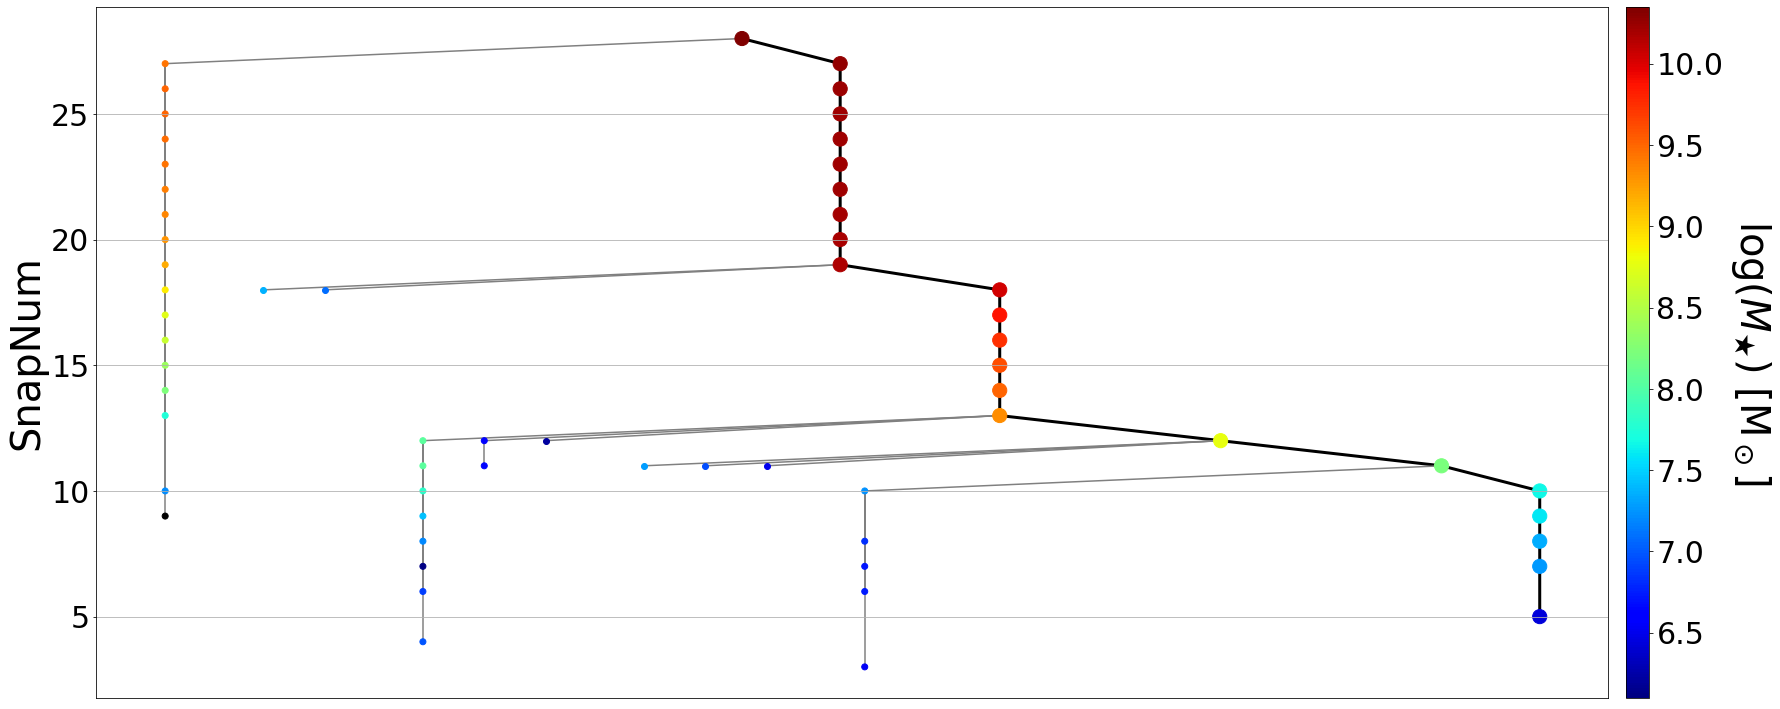

In [16]:
# Plot merger tree
fig0,ax0=mtt.plot_merger_tree(tree,myIDs['GalaxyID'],myIDs['LastProgID'],myIDs['TopLeafID'],
                              yvar='SnapNum',invert_yaxis=False,cmap='jet',
                              color_var='Stars_Mass',log_colorvar=True,
                              color_var_label=r'$\log(M_\bigstar)~[\rm{M}_\odot]$',
                              full_tree=True,plot_bad_color=True)
plt.grid()


In [17]:
# EoP

**Guardamos los datos**

In [7]:
import os
pwd = os.getcwd()

In [8]:
# Carpeta donde guardar archivo. Dejar un caracter 'vacío' para descargar los datos
# en la misma carpeta desde donde se ejecuta la notebook.
download_folder = pwd

# Nombre del archivo que guardará los datos descargados
filename='Tree_max_mass.dat'


In [9]:
# Abrir el archivo donde se guardarán los datos
outf=open(download_folder+'/'+filename,'w')

# Transformar el diccionario a una tabla ascii
data_ascii=Table(data)

# Escribir los datos al archivo
data_ascii.write(outf,format='csv')

# Cerrar el archivo
outf.close()

In [46]:
download_folder+'/'+filename

'/home/ramiro/Facultad/Tesis/Python/Merger_trees/Tree_max_mass.hdf5'

In [ ]:
# dictionary={key1:value,key2:value,....}
